In [17]:
import json
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from src.utils.UsefulPaths import Paths
from sklearn.cluster import KMeans
from src.utils.KnnUtils import OptimalCluster
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [18]:
paths = Paths()

with open(paths.json_subsectors, 'r') as file:
    subsectors = json.load(file)

In [19]:
df_abstract_patents = pd.read_csv(os.path.join(paths.data_processed, 'abstract_patents.csv'))

In [20]:
slice_number = 10000
df_sliced = df_abstract_patents[:slice_number]
df_sliced.to_csv(os.path.join(paths.data_processed, 'abstract_patents_sliced.csv'), index=False)
df_sliced

,publication_number,abstract,word_count,patent_id,app_name,app_year,city,country,country_name,ecosystem,grant_date,grant_year,app_date,class_concat,class_distinct_count,class_ipc_concat,class_ipc_distinct_count
0,20180152842,"A method, and a mobile device adapted thereto,...",80,20180152842,Moorim Kim,2018,Seoul,KR,"Korea, Republic of",Seoul,2018-05-31 00:00:00+00:00,2018,2018-01-29 00:00:00+00:00,"H04M,H04W,G06F",3.00,"G06F,H04M,H04W",3.00
1,20180140889,A dumbbell with a selectable number of weight ...,131,20180140889,Per HÖGLUND,2018,Jonkoping,SE,Sweden,Jonkoping,2018-05-24 00:00:00+00:00,2018,2018-01-03 00:00:00+00:00,A63B,1.00,A63B,1.00
2,20180143803,A virtual assistant AI system that may be conn...,83,20180143803,David Placa,2018,San Francisco,US,United States,Silicon Valley,2018-05-24 00:00:00+00:00,2018,2018-01-16 00:00:00+00:00,G06F,1.00,G06F,1.00
3,20180169402,Connector assemblies that are separate from me...,101,20180169402,Patrick Wells,2018,Columbia Heights,US,United States,Minneapolis,2018-06-21 00:00:00+00:00,2018,2018-02-15 00:00:00+00:00,"H01R,A61N",2.00,"A61N,H01R",2.00
4,20180163931,"An LED tube lamp, comprising a lamp tube, whic...",130,20180163931,Aiming Xiong,2018,Jiaxing,CN,China,Hangzhou,2018-06-14 00:00:00+00:00,2018,2018-02-06 00:00:00+00:00,"F21Y,F21K,F21V,H05B",4.00,"F21K,F21V,F21Y,H05B",4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,20180315125,Systems and methods for dynamic risk modeling ...,133,20180315125,Kent Zheng,2018,London,GB,United Kingdom,Greater London;London,2018-11-01 00:00:00+00:00,2018,2018-04-27 00:00:00+00:00,"G06N,G06Q",2.00,"G06N,G06Q",2.00
9996,20180315067,The present disclosure describes a computer pr...,87,20180315067,Chris Osborn,2018,Los Altos,US,United States,Silicon Valley,2018-11-01 00:00:00+00:00,2018,2018-04-24 00:00:00+00:00,G06Q,1.00,G06Q,1.00
9997,20180298868,An electric starting system for an internal co...,138,20180298868,James Nommensen,2018,Oak Creek,US,United States,NaN,2018-10-18 00:00:00+00:00,2018,2018-06-22 00:00:00+00:00,"H01M,B08B,F02P,F02N,A01D,B60T",6.00,"A01D,B08B,B60T,F02N,F02P,H01M",6.00
9998,20180332835,A dual-bearing reel includes a first reel body...,147,20180332835,Kunio TAKECHI,2018,Osaka,JP,Japan,Osaka,2018-11-22 00:00:00+00:00,2018,2018-01-30 00:00:00+00:00,A01K,1.00,A01K,1.00


In [21]:
embedder = SentenceTransformer('bert-base-uncased')

2023-11-03 00:40:50,808 - INFO - Load pretrained SentenceTransformer: bert-base-uncased
2023-11-03 00:40:51,242 - DEBUG - https://huggingface.co:443 "GET /api/models/bert-base-uncased HTTP/1.1" 200 19779
2023-11-03 00:40:51,456 - DEBUG - https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/1dbc166cf8765166998eff31ade2eb64c8a40076/.gitattributes HTTP/1.1" 200 0
2023-11-03 00:40:51,620 - DEBUG - https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/1dbc166cf8765166998eff31ade2eb64c8a40076/LICENSE HTTP/1.1" 200 0
2023-11-03 00:40:51,789 - DEBUG - https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/1dbc166cf8765166998eff31ade2eb64c8a40076/README.md HTTP/1.1" 200 0
2023-11-03 00:40:51,953 - DEBUG - https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json HTTP/1.1" 200 0
2023-11-03 00:40:52,116 - DEBUG - https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/1dbc166cf8765166998eff31ade2eb64c8a40076/coreml/fill-

In [22]:
sentences = list(df_sliced.abstract)

In [23]:
sentences_embeddings = embedder.encode(sentences)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [24]:
sentences_embeddings_normalized = sentences_embeddings / np.linalg.norm(x=sentences_embeddings, axis=1, keepdims=True)

2023-11-03 00:55:55,844 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-03 00:55:55,846 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Optimal k for elbow method: 12
Optimal k for silhouette method: 11


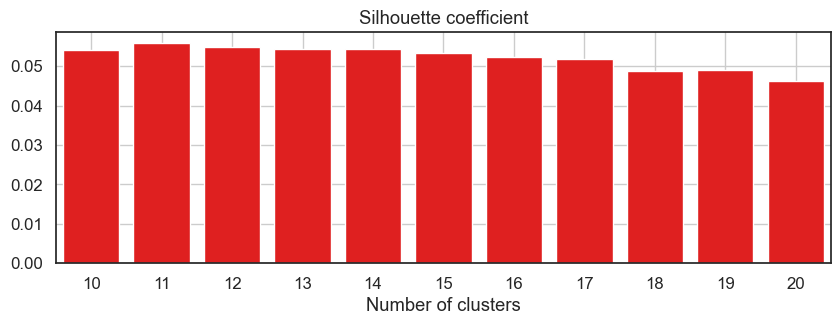

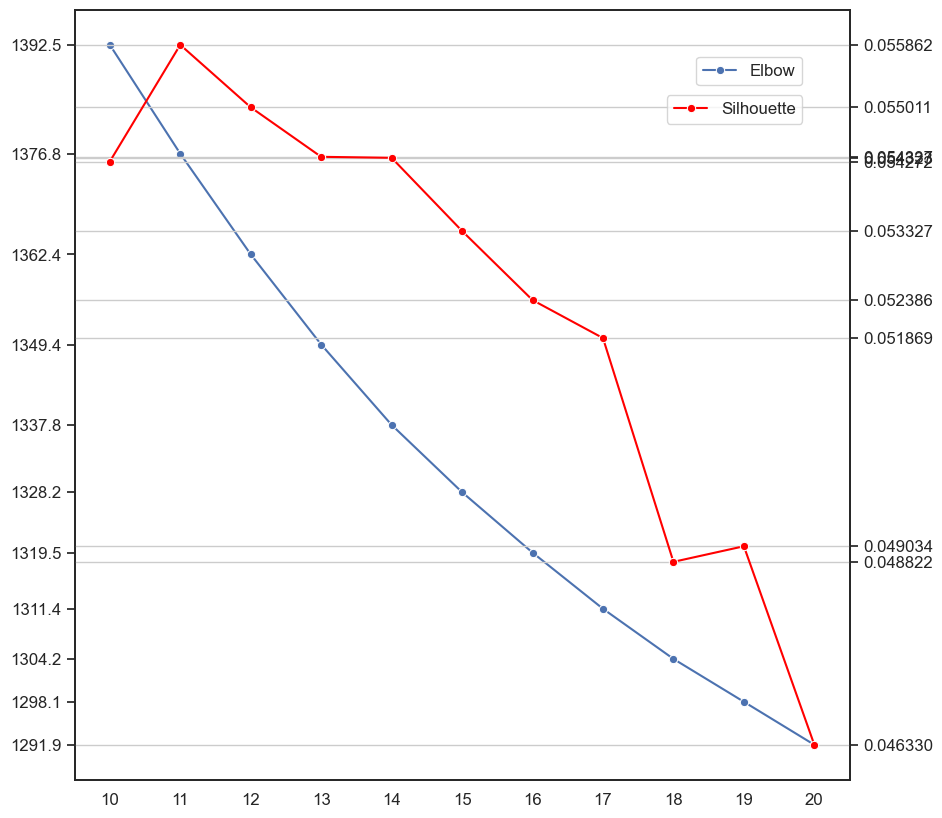

In [25]:
optimal_clusters = OptimalCluster(data=sentences_embeddings_normalized, n_cluster_min=10, n_cluster_max=20, random_state=42)

In [26]:
knn_model = KMeans(n_clusters=18, random_state=42, n_init='auto')
knn_model.fit(sentences_embeddings_normalized)
knn_labels = knn_model.labels_
print(knn_labels)

[3 4 9 ... 8 4 0]


In [27]:
df_new = pd.DataFrame({'abstract': sentences, 'class': knn_labels})
df_new

,abstract,class
0,"A method, and a mobile device adapted thereto,...",3
1,A dumbbell with a selectable number of weight ...,4
2,A virtual assistant AI system that may be conn...,9
3,Connector assemblies that are separate from me...,7
4,"An LED tube lamp, comprising a lamp tube, whic...",4
...,...,...
9995,Systems and methods for dynamic risk modeling ...,16
9996,The present disclosure describes a computer pr...,9
9997,An electric starting system for an internal co...,8
9998,A dual-bearing reel includes a first reel body...,4
